## A modifed KdSampler object that can read in initial Kd estimates

In [49]:
import pandas as pd
import numpy as np
from natsort import natsort_keygen
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import copy


class KdSampler(object):
    """A class to store input data and perform posterior sampling to infer Kd values"""

    def __init__(self, seq_read_fn='06_HighThroughputDesign_FluH1_Gen2_relax.dat', 
                 log10Kd_baseline = -6.0, log10Kd_mu = 0.532, log10Kd_gamma = 0.7045, verbose=True):
        """Initialize the class."""
        
        if verbose:
            print('Initializing the class...')
            
        # get the A8, A13, A18 sequences
        self.wt_sequences = self.get_wt_sequences(verbose=verbose)
        
        # Read in and curate the datatable
        self.df2 = self.get_dataframe(seq_read_fn=seq_read_fn, verbose=verbose, show_df=False)
        self.sequences = self.df2['Sequence']
        self.N = len(self.sequences)
        
        # extract sequence read counts and fractions
        counts_col = '[rd0_seqMatch,rd2_1000nM_seqMatch,rd2_100nM_seqMatch,rd2_10nM_seqMatch,rd2_1nM_seqMatch]'
        self.counts = np.array([eval(row) for row in self.df2[counts_col]])
        self.totals = self.counts.sum(axis=0)
        self.fractions = self.counts/self.totals
        
        #######################################
        # Data structures for MCMC sampling
        self.log10HA_conc = np.array([-6.0, -7.0, -8.0, -9.0])
        self.HA_conc = np.array([1.0e-6, 1.0e-7, 1.0e-8, 1.0e-9])
        self.num_HA_conc = len(self.HA_conc)

        self.log10Kd_baseline = log10Kd_baseline  # log10Kd of the wt_sequences  (-6.0)
        self.log10Kd_mu = log10Kd_mu        # "mu" = location of the Cauchy
        self.log10Kd_gamma = log10Kd_gamma  # "gamma" = \Delta log10Kd of 
        self.log10Kd = self.log10Kd_baseline*np.ones(self.N)   # An array of log10Kd values for each sequence 

        assert self.counts.shape[1] == 5
        self.M = self.counts[0:self.N, 1:5]
        assert self.M.shape[1] == 4
        if (0):
            print('self.M.shape', self.M.shape)
        self.M_sum = self.M.sum(axis=0)
        
        self.w = self.counts[0:self.N, 0]  # the weights from the initial yeast pool
        # If any of the weights are zero, add a pseudocount
        for i in range(self.N):
            if self.w[i] == 0:
                self.w[i] = 1.0

        # for efficient array computation, we will fill arrays with shape of M (N,4)

        self.w_shapeM = np.transpose(np.tile(self.w, (self.num_HA_conc,1))).astype(float)
        if (1):
            print('self.w_shapeM.shape', self.w_shapeM.shape)

        self.L_shapeM = np.tile(self.HA_conc, (self.N,1))
        if (1):
            print('self.L_shapeM.shape', self.L_shapeM.shape)

        self.log10Kd_shapeM = np.zeros((self.N, self.num_HA_conc))
        self.f_shapeM       = np.zeros((self.N, self.num_HA_conc))
        
        # for storing trajectories
        self.Kd_grid_traj = []
        self.u_traj = []
        self.step_traj = []
        

    def get_wt_sequences(self, fromfile=False, verbose=True):
        """Get the A8, A13 and A18 sequences."""
        
        if verbose:
            print('Retrieving A8, A13 and A18 sequences...', end='')
              
        if (not fromfile):
            # Read in sequence data for A8, A13 and A18
            self.A8_sequence  = 'TSRVRATSKFAALIAAEIAREFGYTVDVQEVNGQWEVTFD' # A8
            self.A13_sequence = 'CIEISVTTPFACQIAAEIWRAFGYEVKIDDDNGNCRLHVC' # A13
            self.A18_sequence = 'CQDYTFTDPFACQIAAEILRDFGYDCTVQTNNGECRVRCC' # A18

        else:
            self.A8_seqfile = 'A8_sequence.afasta'
            self.A13_seqfile = 'A13_sequence.afasta'
            self.A18_seqfile = 'A18_sequence.afasta'
        
            self.A8_sequence = open(self.A8_seqfile).readlines()[0].replace('\n','')
            self.A13_sequence = open(self.A13_seqfile).readlines()[0].replace('\n','')
            self.A18_sequence = open(self.A18_seqfile).readlines()[0].replace('\n','')
            
        self.wt_sequences = [self.A8_sequence, self.A13_sequence, self.A18_sequence]

        if verbose:
            print('...Done')

        return self.wt_sequences
        
        
    def get_dataframe(self, seq_read_fn='06_HighThroughputDesign_FluH1_Gen2_relax.dat', verbose=False, show_df=False):
        """Read and curate the datatable, skipping all the info lines, so it's more managable."""

        if verbose:
            print('Getting input data...', end='')
            
        # find the header row where the data starts
        fin = open(seq_read_fn, 'r')
        lines = fin.readlines()
        fin.close()
        
        while lines[0][0:4] != '# ID':  
            lines.pop(0)
        lines[0] = lines[0].replace('# ID', '#ID')  # get rid of the space between # and ID !

        data = [line.split(' ') for line in lines]
        headers = data[0]
        self.df2 = pd.DataFrame([fields[1:] for fields in data[1:]]) # fields have '' for 1st element; skip it!
        
        self.df2.columns = headers
        # print('self.df2.columns', self.df2.columns)
        if show_df:
            print('self.df2', self.df2) 
        if verbose:
            print('...Done.')
        return self.df2


    
    def u(self, Kd_grid_indices, debug=False):
        """Returns the neg-log posterior probability for a given set of \{ K_{d,i} \}

        INPUTS
        log10_Kd   -  a np.array of dim (N,) with a set of dissociation constants (in units M)

        PARAMETERS
        """
        
        # Update the log10Kd_shapeM array based on the current Kd indices
        log10Kd = self.log10Kd_grid[Kd_grid_indices]
        self.log10Kd_shapeM = np.transpose(np.tile(log10Kd, (self.num_HA_conc,1)))
        
        # Update the f_shapeM array based on the current Kd indices
        self.f_shapeM = self.w_shapeM * self.L_shapeM/(np.power(10.0,self.log10Kd_shapeM) + self.L_shapeM)
        if (debug):
            print('self.f_shapeM', self.f_shapeM)

        # first term
        result = np.sum(-1.0 * self.M * np.log(self.w_shapeM * self.f_shapeM))
        if debug:
            print('result', result)

        # second term
        self.f_sum = self.f_shapeM.sum(axis=0)
        result += np.sum(self.M_sum*np.log(self.f_sum))
        if debug:
            print('result 2', result)

        # third term - the cauchy penalty       
        cauchy_penalties = self.cauchy_penalty_grid[ Kd_grid_indices ]
        result += np.sum(cauchy_penalties)
        if debug:
            print('result 3', result)

        return result

    
    def update(self, rows_to_update, row_Kd_grid_indices):
        """Update the energy terms that depend on the Kd,i's'"""
         
        self.log10Kd_shapeM = np.zeros((self.N, self.num_HA_conc))
        self.f_shapeM       = np.zeros((self.N, self.num_HA_conc))

        log10Kd_to_update = self.log10Kd_grid[row_Kd_grid_indices]
        self.log10Kd_shapeM= np.transpose(np.tile(log10Kd_to_update, (self.num_HA_conc,1)))
        if (1):
            print('self.log10Kd_shapeM.shape', self.log10Kd_shapeM.shape)

        self.f_shapeM[ rows_to_update, :] = self.w_shapeM[ rows_to_update, :] * self.L_shapeM[ rows_to_update, :]/(np.power(10.0,self.log10Kd_shapeM[ rows_to_update, :]) + self.L_shapeM[ rows_to_update, :])
        if (1):
            print('self.f_shapeM', self.f_shapeM)
        
    def read_initial_log10Kd_from_csv(self, initial_log10Kds_csv, log10Kd_grid, debug=False):
        """Read the initial log10Kd from a cvs file, formatted like so:
        
        ,SeqIndex,Sequence,Log10Kd
        0,0,CYTTESPSPFAAEIVAQIAAEFNWEVHVQQHGDTVKVQVC,-3.2999999999999865
        1,1,TREINARSPFAAWIAAEIAKEFGYEVEVHKKNGKFTLHSQ,-6.899999999999995
        2,2,TWTS
        ...
        
        INPUTS
        
        initial_log10Kds_csv   - filename of the *.csv file
        log10Kd_grid           - a grid of possible log10Kd values
        
        RETURNS
        
        log10Kd_values         - an array with all log10Kd values
        Kd_grid_indices        - an array with the corresponding grid indices for each log10Kd value
        """
        
        df_initial_log10Kds = pd.read_csv(self.initial_log10Kds_csv)
        initial_log10Kds = df_initial_log10Kds['Log10Kd']
        
        # Find the grid values closest to the input Kds
        Kd_grid_indices = []
        for i in range(len(initial_log10Kds)):
            value = initial_log10Kds[i]
            closest_grid_index = np.argsort( np.abs(log10Kd_grid - value) )[0]
            Kd_grid_indices.append(closest_grid_index)
            if debug:
                print(i, value, closest_grid_index)
              
        return initial_log10Kds, np.array(Kd_grid_indices)
        
        
    def sample(self, nsteps = 100000, nmove = 10, log10Kd_min=-9.0, log10Kd_max=-3.0, dlog10Kd = 0.1,
              print_every = 1000, traj_every = 100, initial_log10Kds_csv=None):
        """Perform MCMC sample of the posterior probability of K_d,i values.
        
        PARAMETERS 
        
        RETURN        
        """
        
        # Initialize energies
        self.log10Kd_grid = np.arange(log10Kd_min, log10Kd_max, dlog10Kd)
        self.Kd_grid = np.power(10.0, self.log10Kd_grid)
        self.ngrid = len(self.log10Kd_grid)
        
        self.initial_log10Kds_csv = initial_log10Kds_csv
        
        if self.initial_log10Kds_csv == None:
            self.current_Kd_grid_indices = np.array(self.N*[int(self.ngrid/2)])
        else:
            # Read 'Log10Kd' from the csv file
            log10Kd_values, self.current_Kd_grid_indices = self.read_initial_log10Kd_from_csv(self.initial_log10Kds_csv, self.log10Kd_grid)
            
        self.current_log10Kd = self.log10Kd_grid[self.current_Kd_grid_indices]       
        # print('self.current_log10Kd', self.current_log10Kd)
        
        # Cauchy prior penalty
        self.cauchy_penalty_grid = np.log( (self.log10Kd_grid - self.log10Kd_baseline - self.log10Kd_mu)**2.0 + self.log10Kd_gamma**2.0 )
        # print('self.cauchy_penalty_grid', self.cauchy_penalty_grid)                        

        self.current_u = self.u(self.current_Kd_grid_indices)
        
        # nmove = 5   # number of Kd values to move at a time

        accepted = 0.0
        for step in range(nsteps):

            self.current_u = self.u(self.current_Kd_grid_indices)

            # Propose a move

            ## choose nmove Kd indices at random
            Ind = np.random.choice(self.N, size=nmove, replace=False)
            move_dirs = np.random.choice([-1,1], size=nmove, replace=True)  # move the indices up or down

            new_Kd_grid_indices = copy.copy(self.current_Kd_grid_indices)
            new_Kd_grid_indices[Ind] = np.clip(self.current_Kd_grid_indices[Ind] + move_dirs, 0, self.ngrid-1)
            # NOTE: clip() keeps grid indices in range
            
            new_u = self.u(new_Kd_grid_indices)

            # Accept or reject according to the Metropolis criterion
            accept = False
            if new_u < self.current_u:
                accept = True
            else:
                if np.exp(-1.0*(new_u - self.current_u)) > np.random.rand():
                    accept = True

            if accept:
                self.current_u = new_u
                self.current_Kd_grid_indices = new_Kd_grid_indices
                accepted += 1.0

            if step%print_every == 0:
                print('step', step, 'of', nsteps, 'acc =', accept, 'ratio', accepted/(step+1.0), 'current_u', self.current_u)

            # store the 
            if step%traj_every == 0:
                self.Kd_grid_traj.append(self.current_Kd_grid_indices)
                self.u_traj.append(self.current_u)
                self.step_traj.append(step)



In [41]:
s = KdSampler()

# Perform some sampling
## s.sample(nsteps=100000, print_every=100)
s.sample(nsteps=1000000, print_every=1000, nmove = 20, log10Kd_min=-9.0, log10Kd_max=-3.0, dlog10Kd = 0.05,
        initial_log10Kds_csv = 'initial_Log10Kd_estimates_20230913.csv')

Initializing the class...
Retrieving A8, A13 and A18 sequences......Done
Getting input data......Done.
self.w_shapeM.shape (15490, 4)
self.L_shapeM.shape (15490, 4)
step 0 of 1000000 acc = False ratio 0.0 current_u 12024215.455450187
step 1000 of 1000000 acc = True ratio 0.3166833166833167 current_u 12020822.600481186
step 2000 of 1000000 acc = True ratio 0.2958520739630185 current_u 12018324.735639464
step 3000 of 1000000 acc = True ratio 0.28757080973008997 current_u 12016143.087693354
step 4000 of 1000000 acc = False ratio 0.2786803299175206 current_u 12014385.486526364
step 5000 of 1000000 acc = True ratio 0.2699460107978404 current_u 12012837.970757375
step 6000 of 1000000 acc = False ratio 0.26128978503582734 current_u 12011547.497607738
step 7000 of 1000000 acc = False ratio 0.251249821454078 current_u 12010548.892601883
step 8000 of 1000000 acc = False ratio 0.24371953505811775 current_u 12009546.47227211
step 9000 of 1000000 acc = False ratio 0.23764026219308965 current_u 1200

Text(0, 0.5, '$K_d$ (M)')

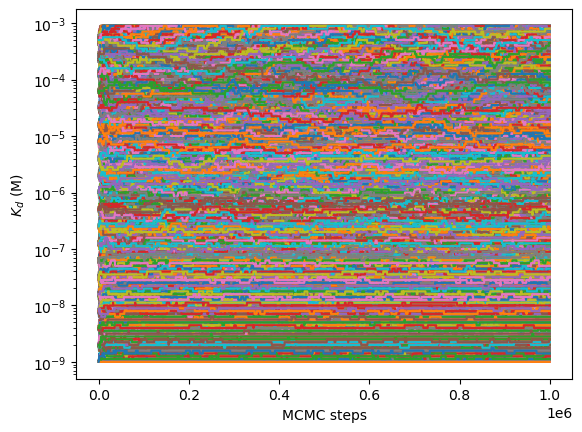

In [42]:
# plot the Kd convergenece

Kd_traj = s.Kd_grid[np.array(s.Kd_grid_traj)]
plt.plot(s.step_traj,Kd_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')

Text(0, 0.5, 'energy')

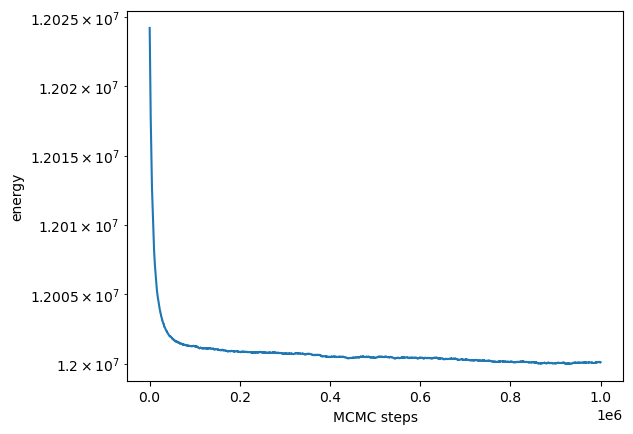

In [45]:
# Plot the convergence of the energy

plt.plot(s.step_traj, s.u_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('energy')

Text(0.5, 0, '$K_d$ (M)')

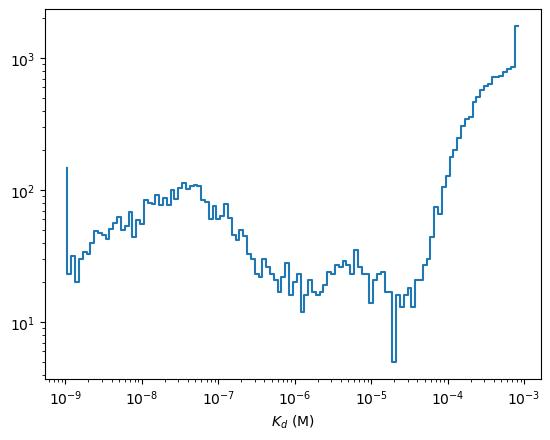

In [47]:
logbins = 10.0**(np.arange(-9,-3, 0.05))
Kd_hist, Kd_binedges = np.histogram(Kd_traj[-1,:], bins=logbins)
Kd_bincenters = (Kd_binedges[0:-1] + Kd_binedges[1:])/2.0

plt.step(Kd_bincenters, Kd_hist)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$K_d$ (M)')

Text(0, 0.5, '$K_d$ (M)')

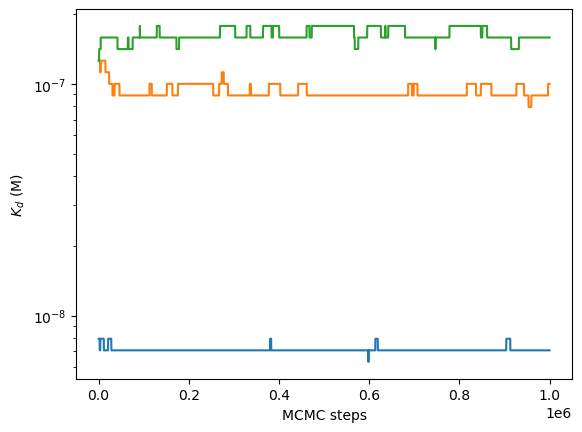

In [48]:
# plot the Kd convergenece for a single sequence

# Find the Kd of the WT sequences
k_A8 = list(s.sequences).index(s.A8_sequence)
k_A13 = list(s.sequences).index(s.A13_sequence)
k_A18 = list(s.sequences).index(s.A18_sequence)

Kd_traj = s.Kd_grid[np.array(s.Kd_grid_traj)]
plt.plot(s.step_traj,Kd_traj[:,k_A8], label='A8')
plt.plot(s.step_traj,Kd_traj[:,k_A13], label='A13')
plt.plot(s.step_traj,Kd_traj[:,k_A18], label='A18')

plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')

In [50]:
#####################################################
# Save the final frame of the traj as our round2 20230913 estimates of log10Kd

log10Kd_estimates = (s.log10Kd_grid[ np.array(s.Kd_grid_traj) ])[-1,:] # <-- last frame for alll 15490 sequences
print('log10Kd_estimates', log10Kd_estimates)
print('log10Kd_estimates.shape', log10Kd_estimates.shape)

#####################################################
# create an Empty DataFrame object
df_log10Kd_estimates = pd.DataFrame()

# append columns to an empty DataFrame
df_log10Kd_estimates['SeqIndex'] = range(log10Kd_estimates.shape[0])
df_log10Kd_estimates['Sequence'] = s.sequences
df_log10Kd_estimates['Log10Kd'] = log10Kd_estimates

outfile_csv = 'round2_Log10Kd_estimates_20230913.csv'
print(f'Writing round2 log10Kd estimates to {outfile_csv}...')
df_log10Kd_estimates.to_csv(outfile_csv)
print('...Done.')

log10Kd_estimates [-3.1  -6.9  -3.3  ... -3.15 -3.1  -3.3 ]
log10Kd_estimates.shape (15490,)
Writing round2 log10Kd estimates to round2_Log10Kd_estimates_20230913.csv...
...Done.


# Round 3: 10M steps!

In [51]:
s = KdSampler()

# Perform some sampling
## s.sample(nsteps=100000, print_every=100)
s.sample(nsteps=10000000, print_every=10000, traj_every = 1000, nmove = 20, log10Kd_min=-9.0, log10Kd_max=-3.0, dlog10Kd = 0.05,
        initial_log10Kds_csv = 'round2_Log10Kd_estimates_20230913.csv')

Initializing the class...
Retrieving A8, A13 and A18 sequences......Done
Getting input data......Done.
self.w_shapeM.shape (15490, 4)
self.L_shapeM.shape (15490, 4)
step 0 of 10000000 acc = False ratio 0.0 current_u 12000098.046278967
step 10000 of 10000000 acc = False ratio 0.05599440055994401 current_u 12000032.444759127
step 20000 of 10000000 acc = False ratio 0.05474726263686815 current_u 12000026.808578253
step 30000 of 10000000 acc = False ratio 0.054398186727109096 current_u 12000029.338164045
step 40000 of 10000000 acc = False ratio 0.05374865628359291 current_u 12000003.97749813
step 50000 of 10000000 acc = False ratio 0.054478910421791565 current_u 12000047.577735567
step 60000 of 10000000 acc = False ratio 0.05441575973733771 current_u 12000027.52810702
step 70000 of 10000000 acc = False ratio 0.054170654704932784 current_u 11999976.407131169
step 80000 of 10000000 acc = False ratio 0.054299321258484266 current_u 11999999.597331999
step 90000 of 10000000 acc = False ratio 0.

Text(0, 0.5, '$K_d$ (M)')

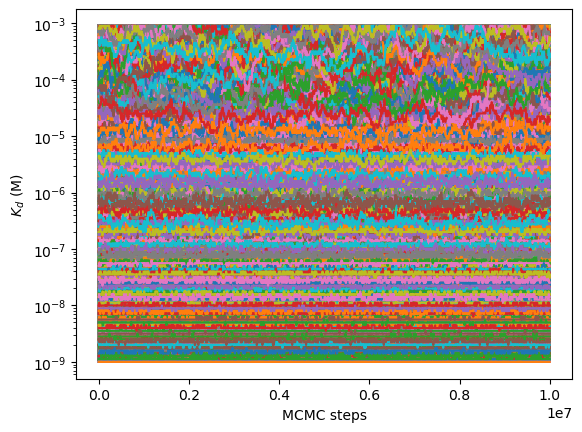

In [52]:
# plot the Kd convergenece

Kd_traj = s.Kd_grid[np.array(s.Kd_grid_traj)]
plt.plot(s.step_traj,Kd_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')

In [67]:
#####################################################
# Save the mean and std of last 80% of the traj as the
# round 20230914 estimates of log10Kd and its uncertainty

# print('np.array(s.Kd_grid_traj)', np.array(s.Kd_grid_traj))
#print('np.array(s.Kd_grid_traj).shape', np.array(s.Kd_grid_traj).shape)

full_log10Kd_traj = s.log10Kd_grid[ np.array(s.Kd_grid_traj) ]  # <-- size (nframes, nsequences)
nframes, nsequences = full_log10Kd_traj.shape

frame_20pc = int(nframes*2.0/5.0)
log10Kd_estimates = full_log10Kd_traj[frame_20pc:,:].mean(axis=0) # <-- mean value for all 15490 sequences
log10Kd_estimates_std = full_log10Kd_traj[frame_20pc:,:].std(axis=0) # <-- mean value for all 15490 sequences
print('log10Kd_estimates', log10Kd_estimates)
print('log10Kd_estimates_std', log10Kd_estimates_std)
print('log10Kd_estimates.shape', log10Kd_estimates.shape)

#####################################################
# create an Empty DataFrame object
df_log10Kd_estimates = pd.DataFrame()

# append columns to an empty DataFrame
df_log10Kd_estimates['SeqIndex'] = range(log10Kd_estimates.shape[0])
df_log10Kd_estimates['Sequence'] = s.sequences
df_log10Kd_estimates['Log10Kd'] = log10Kd_estimates
df_log10Kd_estimates['Log10Kd Uncertainty'] = log10Kd_estimates_std

# write round 2 estimates to csv
outfile_csv = 'round2_Log10Kd_estimates_20230914.csv'
print(f'Writing round2 log10Kd estimates to {outfile_csv}...')
df_log10Kd_estimates.to_csv(outfile_csv)
print('...Done.')

#####################################################
# write round2 full trajectories as numpy objects
np.save('round2_full_log10Kd_traj', full_log10Kd_traj)
np.save('round2_steps_traj', s.step_traj)
np.save('round2_u_traj', s.u_traj)


log10Kd_estimates [-3.41580833 -6.898675   -3.337475   ... -3.28258333 -3.21938333
 -3.454175  ]
log10Kd_estimates_std [0.24779463 0.03763192 0.19157733 ... 0.16592416 0.14257496 0.21277254]
log10Kd_estimates.shape (15490,)
Writing round2 log10Kd estimates to round2_Log10Kd_estimates_20230914.csv...
...Done.


Text(0, 0.5, 'energy')

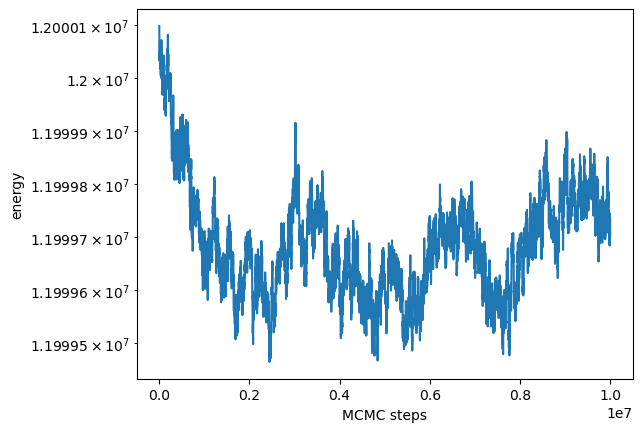

In [54]:
# Plot the convergence of the energy

plt.plot(s.step_traj, s.u_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('energy')


Text(0.5, 0, '$K_d$ (M)')

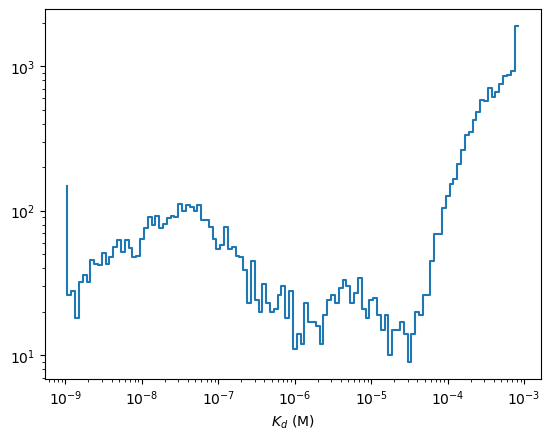

In [55]:
logbins = 10.0**(np.arange(-9,-3, 0.05))
Kd_hist, Kd_binedges = np.histogram(Kd_traj[-1,:], bins=logbins)
Kd_bincenters = (Kd_binedges[0:-1] + Kd_binedges[1:])/2.0

plt.step(Kd_bincenters, Kd_hist)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$K_d$ (M)')

seqindices [14356, 4379, 8304]


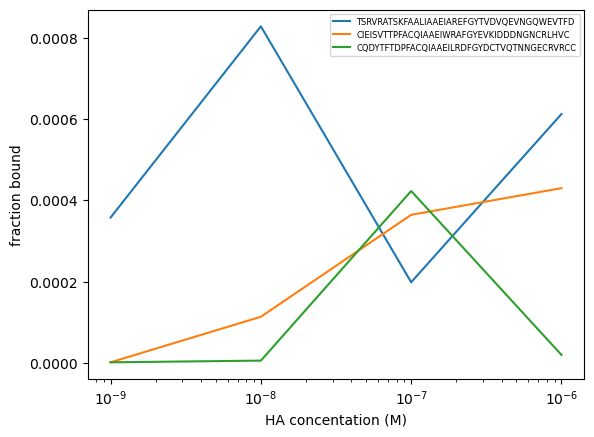

In [68]:
# Let's look at the sampling for the three WT sequences

seqnames   = ['A8', 'A13', 'A8']
seqindices = []
seqindices.append( list(s.sequences).index(s.A8_sequence) )
seqindices.append( list(s.sequences).index(s.A13_sequence) )
seqindices.append( list(s.sequences).index(s.A18_sequence) )
print('seqindices', seqindices)

plt.figure()
for i in seqindices:
    plt.plot(s.HA_conc, s.fractions[i,1:5], label=s.sequences[i])
plt.xscale('log')
plt.xlabel('HA concentation (M)')
plt.ylabel('fraction bound')
plt.legend(loc='best', fontsize=6)


Text(0, 0.5, '$K_d$ (M)')

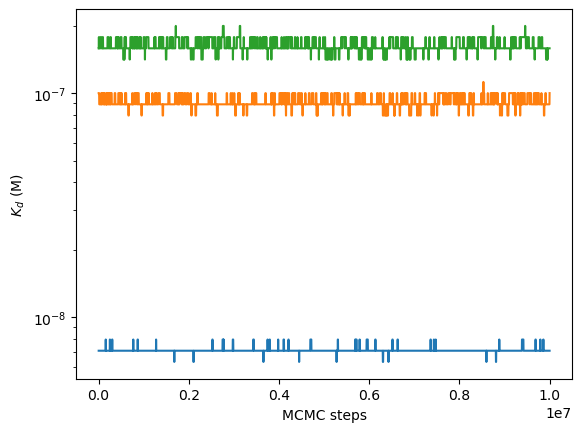

In [71]:
Kd_traj = s.Kd_grid[np.array(s.Kd_grid_traj)]

for i in range(len(seqindices)):
    j = seqindices[i]
    plt.plot(s.step_traj, Kd_traj[:,j], label=seqnames[i])
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')

40
k_A8 14356
WT_log10Kd_A8 -8.148741666667513 +/- 0.008878809823894884


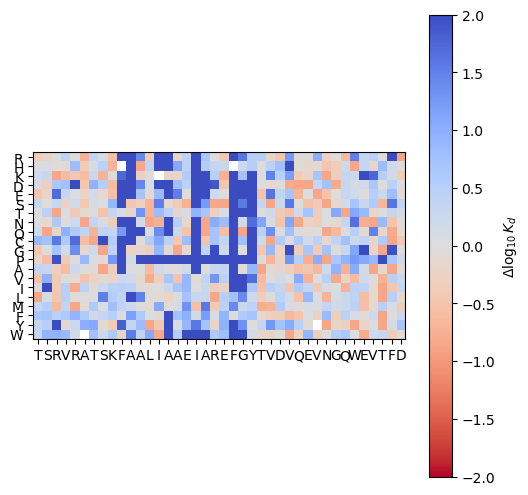

In [83]:
# Let's make plot of the Kds of all single-point mutants for A8

residues = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
positions = range(len(s.A8_sequence))
nres = len(positions)
print(nres)
# Store a 20 x n array of the *indices* of each sequence, if found.

SSM_indices_A8 = np.zeros( (20, nres) )
SSM_dGs_in_RT_A8  = np.zeros( (20, nres) )
SSM_log10Kds_A8  = np.zeros( (20, nres) )

# create lists for df output
SSM_sequences_df_A8 = []
SSM_log10Kds_df_A8 = []
SSM_positions_df_A8 = []
SSM_residues_df_A8 = []

for i in range(len(residues)):
    r = residues[i]
    for j in positions:
        mutant_sequence = s.A8_sequence[0:j] + r + s.A8_sequence[(j+1):]
        if (0):
            print(i, j, mutant_sequence, end='')
        
        try:
            k = list(s.sequences).index(mutant_sequence)
            # print('... found:', k)
            SSM_indices_A8[i,j] = k
            SSM_dGs_in_RT_A8[i,j] = np.log( np.power(10.0, log10Kd_estimates[k]) )   # <-- the last sample in the Kd trajectory!
            SSM_log10Kds_A8[i,j] = log10Kd_estimates[k]
        except:
            # print('... NOT FOUND. :(')
            SSM_indices_A8[i,j] = -1    # Use -1 for an index that is not there
            SSM_dGs_in_RT_A8[i,j] = -1.0
            SSM_log10Kds_A8[i,j] = None

        # store this info for the output dataframe
        SSM_sequences_df_A8.append(mutant_sequence)
        SSM_log10Kds_df_A8.append(SSM_log10Kds_A8[i,j])
        SSM_positions_df_A8.append(j)
        SSM_residues_df_A8.append(r)

# print(SSM_log10Kds)

# Find the Kd of the WT sequence
k_A8 = list(s.sequences).index(s.A8_sequence)
print('k_A8', k_A8)
WT_log10Kd_A8 = log10Kd_estimates[k_A8]
WT_log10Kd_A8_std = log10Kd_estimates_std[k_A8]
print('WT_log10Kd_A8', WT_log10Kd_A8, '+/-', WT_log10Kd_A8_std)

# print('SSM_log10Kds_A8', SSM_log10Kds_A8)
dSSM_log10Kds_A8 = SSM_log10Kds_A8 - (WT_log10Kd_A8)  # shift in log_10 Kd from 1 uM

fig, ax = plt.subplots(figsize=(6,6))
plt.imshow( dSSM_log10Kds_A8, interpolation='none',
           cmap='coolwarm_r', vmin=-2.0, vmax=2.0)

plt.colorbar(label='$\Delta \log_{10} K_d$', ax=ax)
ax.set(xticks=np.arange(0, nres, 1), xticklabels=[l for l in s.A8_sequence]);
ax.set(yticks=np.arange(0, 20, 1), yticklabels=residues);


40
k_A13 4379
WT_log10Kd_A13 -7.038808333333386 +/- 0.026492072975807978


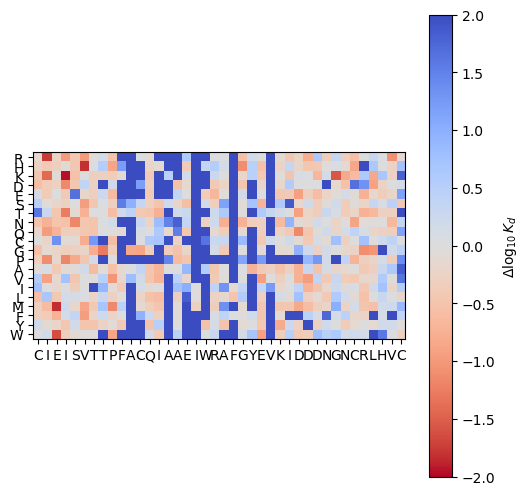

In [85]:
# Let's make plot of the Kds of all single-point mutants for A13

residues = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
positions = range(len(s.A13_sequence))
nres = len(positions)
print(nres)
# Store a 20 x n array of the *indices* of each sequence, if found.

SSM_indices_A13 = np.zeros( (20, nres) )
SSM_dGs_in_RT_A13  = np.zeros( (20, nres) )
SSM_log10Kds_A13  = np.zeros( (20, nres) )

# create lists for df output
SSM_sequences_df_A13 = []
SSM_log10Kds_df_A13 = []
SSM_positions_df_A13 = []
SSM_residues_df_A13 = []

for i in range(len(residues)):
    r = residues[i]
    for j in positions:
        mutant_sequence = s.A13_sequence[0:j] + r + s.A13_sequence[(j+1):]
        if (0):
            print(i, j, mutant_sequence, end='')
        
        try:
            k = list(s.sequences).index(mutant_sequence)
            # print('... found:', k)
            SSM_indices_A13[i,j] = k
            SSM_dGs_in_RT_A13[i,j] = np.log( np.power(10.0, log10Kd_estimates[k]) )   # <-- the last sample in the Kd trajectory!
            SSM_log10Kds_A13[i,j] = log10Kd_estimates[k]
        except:
            # print('... NOT FOUND. :(')
            SSM_indices_A13[i,j] = -1    # Use -1 for an index that is not there
            SSM_dGs_in_RT_A13[i,j] = -1.0
            SSM_log10Kds_A13[i,j] = None

        # store this info for the output dataframe
        SSM_sequences_df_A13.append(mutant_sequence)
        SSM_log10Kds_df_A13.append(SSM_log10Kds_A13[i,j])
        SSM_positions_df_A13.append(j)
        SSM_residues_df_A13.append(r)

# print(SSM_log10Kds)

# Find the Kd of the WT sequence
k_A13 = list(s.sequences).index(s.A13_sequence)
print('k_A13', k_A13)
WT_log10Kd_A13 = log10Kd_estimates[k_A13]
WT_log10Kd_A13_std = log10Kd_estimates_std[k_A13]
print('WT_log10Kd_A13', WT_log10Kd_A13, '+/-', WT_log10Kd_A13_std)

# print('SSM_log10Kds_A13', SSM_log10Kds_A13)
dSSM_log10Kds_A13 = SSM_log10Kds_A13 - (WT_log10Kd_A13)  # shift in log_10 Kd from 1 uM

fig, ax = plt.subplots(figsize=(6,6))
plt.imshow( dSSM_log10Kds_A13, interpolation='none',
           cmap='coolwarm_r', vmin=-2.0, vmax=2.0)

plt.colorbar(label='$\Delta \log_{10} K_d$', ax=ax)
ax.set(xticks=np.arange(0, nres, 1), xticklabels=[l for l in s.A13_sequence]);
ax.set(yticks=np.arange(0, 20, 1), yticklabels=residues);


40
k_A18 8304
WT_log10Kd_A18 -6.7912166666667755 +/- 0.027270614017453024


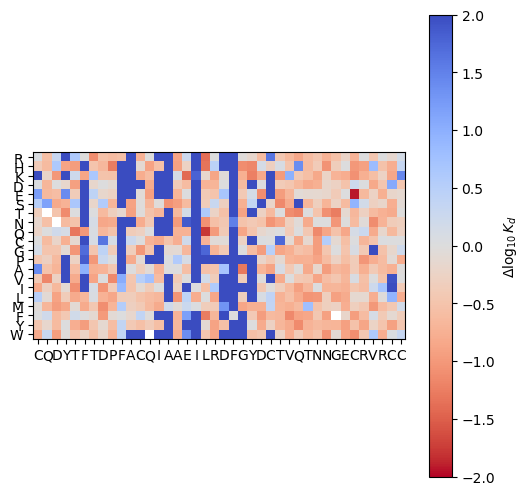

In [86]:
# Let's make plot of the Kds of all single-point mutants for A18

residues = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
positions = range(len(s.A18_sequence))
nres = len(positions)
print(nres)
# Store a 20 x n array of the *indices* of each sequence, if found.

SSM_indices_A18 = np.zeros( (20, nres) )
SSM_dGs_in_RT_A18  = np.zeros( (20, nres) )
SSM_log10Kds_A18  = np.zeros( (20, nres) )

# create lists for df output
SSM_sequences_df_A18 = []
SSM_log10Kds_df_A18 = []
SSM_positions_df_A18 = []
SSM_residues_df_A18 = []

for i in range(len(residues)):
    r = residues[i]
    for j in positions:
        mutant_sequence = s.A18_sequence[0:j] + r + s.A18_sequence[(j+1):]
        if (0):
            print(i, j, mutant_sequence, end='')
        
        try:
            k = list(s.sequences).index(mutant_sequence)
            # print('... found:', k)
            SSM_indices_A18[i,j] = k
            SSM_dGs_in_RT_A18[i,j] = np.log( np.power(10.0, log10Kd_estimates[k]) )   # <-- the last sample in the Kd trajectory!
            SSM_log10Kds_A18[i,j] = log10Kd_estimates[k]
        except:
            # print('... NOT FOUND. :(')
            SSM_indices_A18[i,j] = -1    # Use -1 for an index that is not there
            SSM_dGs_in_RT_A18[i,j] = -1.0
            SSM_log10Kds_A18[i,j] = None

        # store this info for the output dataframe
        SSM_sequences_df_A18.append(mutant_sequence)
        SSM_log10Kds_df_A18.append(SSM_log10Kds_A18[i,j])
        SSM_positions_df_A18.append(j)
        SSM_residues_df_A18.append(r)

# print(SSM_log10Kds)

# Find the Kd of the WT sequence
k_A18 = list(s.sequences).index(s.A18_sequence)
print('k_A18', k_A18)
WT_log10Kd_A18 = log10Kd_estimates[k_A18]
WT_log10Kd_A18_std = log10Kd_estimates_std[k_A18]
print('WT_log10Kd_A18', WT_log10Kd_A18, '+/-', WT_log10Kd_A18_std)

# print('SSM_log10Kds_A18', SSM_log10Kds_A18)
dSSM_log10Kds_A18 = SSM_log10Kds_A18 - (WT_log10Kd_A18)  # shift in log_10 Kd from 1 uM

fig, ax = plt.subplots(figsize=(6,6))
plt.imshow( dSSM_log10Kds_A18, interpolation='none',
           cmap='coolwarm_r', vmin=-2.0, vmax=2.0)

plt.colorbar(label='$\Delta \log_{10} K_d$', ax=ax)
ax.set(xticks=np.arange(0, nres, 1), xticklabels=[l for l in s.A18_sequence]);
ax.set(yticks=np.arange(0, 20, 1), yticklabels=residues);
